In [113]:
## Run pip install -r requirements.txt
%pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

In [115]:
import pandas as pd
# Load the Excel file
complaints_df = pd.read_excel('./PI_Complaints.xlsx')

# Display the first few rows of the data
complaints_df.head()

,Notification Number,er key for sap and saptw notifications,Notification Date,Material Number,Material Description,Brand,Business,Code Description,SAP Damage Code Text,Short Text,...,BreakDown Duration,Build Date,Ship To Customer,Ship To Party,Sold To Customer,Sold To Party,OOB Failure,Material Quantity,subject_long_text sor sap and srctw,Quantity
0,100022,319015549.0,2024-09-05 06:24:00,1153533,Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798,AC611,PATIENT INTERFACE,AC611 _ LEAK,LEAK,Product malfunction / General Catalog Profile ...,...,NaN,NaN,NaN,NaN,30302881.0,"Yagami Co.,Ltd.",No,1.0,NaN,1.0
1,101106,319017578.0,2024-09-05 18:14:00,1104925,L PICO NASAL MASK W/ HGR JPN,PICO,PATIENT INTERFACE,PICO _ PHYS,PHYSICAL DAMAGE,Operation manual failure / PICO MASK /Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,3.0,* 09/05/2024 10:39:50 EST (NMARRONE)\n* Per Er...,3.0
2,101129,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,"DAMAGE,PHYSICAL",Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
3,101249,319018673.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ CONT,CONTAMINATION OBSERVED,foreign substance (hair)/TRILOGY/JAPAN,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:34:15 EST (NMARRONE)\n* Per Er...,1.0
4,101258,319018807.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ COSM,COSMETIC DAMAGE,product scratch/ General Catalog Profile/ Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:36:49 EST (NMARRONE)\n* Per Er...,1.0


## Data Cleaning: Filter out the columns that aren't important

In [116]:

print(sentiments_time_df.dtypes)
print(complaints_df.isnull().sum())

columns_to_drop = [
    'Notification Number'
]
# Drop columns
complaints_cleaned_df = complaints_df.drop(columns=columns_to_drop)

# Display cleaned DataFrame
complaints_cleaned_df.head()

Country                      object
Notification Date    datetime64[ns]
Short Text                   object
Sentiment                   float64
dtype: object
Notification Number                           1
er key for sap and saptw notifications        3
Notification Date                             2
Material Number                               2
Material Description                          2
Brand                                         2
Business                                      2
Code Description                              2
SAP Damage Code Text                        162
Short Text                                    2
Country                                       3
Serial Number                             21675
Catalog Profile                               8
Line Number                                 154
BreakDown Duration                          248
Build Date                                  248
Ship To Customer                            248
Ship To Party             

,er key for sap and saptw notifications,Notification Date,Material Number,Material Description,Brand,Business,Code Description,SAP Damage Code Text,Short Text,Country,...,BreakDown Duration,Build Date,Ship To Customer,Ship To Party,Sold To Customer,Sold To Party,OOB Failure,Material Quantity,subject_long_text sor sap and srctw,Quantity
0,319015549.0,2024-09-05 06:24:00,1153533,Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798,AC611,PATIENT INTERFACE,AC611 _ LEAK,LEAK,Product malfunction / General Catalog Profile ...,Japan,...,NaN,NaN,NaN,NaN,30302881.0,"Yagami Co.,Ltd.",No,1.0,NaN,1.0
1,319017578.0,2024-09-05 18:14:00,1104925,L PICO NASAL MASK W/ HGR JPN,PICO,PATIENT INTERFACE,PICO _ PHYS,PHYSICAL DAMAGE,Operation manual failure / PICO MASK /Japan,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,3.0,* 09/05/2024 10:39:50 EST (NMARRONE)\n* Per Er...,3.0
2,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,"DAMAGE,PHYSICAL",Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
3,319018673.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ CONT,CONTAMINATION OBSERVED,foreign substance (hair)/TRILOGY/JAPAN,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:34:15 EST (NMARRONE)\n* Per Er...,1.0
4,319018807.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ COSM,COSMETIC DAMAGE,product scratch/ General Catalog Profile/ Japan,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:36:49 EST (NMARRONE)\n* Per Er...,1.0


In [117]:
print(complaints_df.head())

  Notification Number  er key for sap and saptw notifications  \
0              100022                             319015549.0   
1              101106                             319017578.0   
2              101129                             319017661.0   
3              101249                             319018673.0   
4              101258                             319018807.0   

    Notification Date Material Number  \
0 2024-09-05 06:24:00         1153533   
1 2024-09-05 18:14:00         1104925   
2 2024-09-05 18:14:00         1128652   
3 2024-09-05 18:19:00          312149   
4 2024-09-05 18:19:00          312149   

                       Material Description           Brand  \
0        Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798           AC611   
1              L PICO NASAL MASK W/ HGR JPN            PICO   
2  S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK           AF541   
3                Disp Exhalation Port Pk/10  PI ACCESSORIES   
4                Disp Exhalation Port Pk/10  PI

In [118]:

# complaints_df = complaints_df[[]]

# needed columns:
  # Country
  # possibly Sold to Party: maybe a trend among party complaints
  # Short Text: short description of complaint/issue
  # SAP Damage Code Text: the type of damage
  # possibly Brand: could be a trend among brands being an issue
  # Notification Date: possible trend among times with complaints
  # OOB Failure

unique_names = complaints_df['Country'].unique()

# Print the unique names
print("Unique Names:", unique_names)

country_code_mapping = {
    'JP': 'Japan',
    'US': 'United States',
    'NL': 'Netherlands',
    'IN': 'India',
    'GB': 'United Kingdom',
    'TH': 'Thailand',
    'FR': 'France',
    'DE': 'Germany',
    'CA': 'Canada',
    'ES': 'Spain',
    'AU': 'Australia',
    'NO': 'Norway',
    'AT': 'Austria',
    'CZ': 'Czech Republic',
    'KR': 'South Korea',
    'CN': 'China',
    'CO': 'Colombia',
    'MT': 'Malta',
    'HR': 'Croatia',
    'BE': 'Belgium',
    'PL': 'Poland',
    'ZA': 'South Africa',
    'JO': 'Jordan',
    'BR': 'Brazil',
    'HK': 'Hong Kong',
    'SE': 'Sweden',
    'IT': 'Italy',
    'EE': 'Estonia',
    'MY': 'Malaysia',
    'CH': 'Switzerland',
    'TR': 'Turkey',
    'PR': 'Puerto Rico',
    'TW': 'Taiwan',
    'SA': 'Saudi Arabia',
    'SG': 'Singapore',
    'GR': 'Greece',
    'Korea Republic of': 'South Korea'  # Handle alternate name
}


# Step 2: Standardize country names using the mapping
complaints_df['Country'] = complaints_df['Country'].replace(country_code_mapping)

# Step 3: Handle NaN values by replacing them with 'Unknown'
complaints_df = complaints_df.dropna(subset=['Country'])




# Step 4: Verify the cleaned country names
unique_names_cleaned = complaints_df['Country'].unique()
print("Cleaned Unique Country Names:", unique_names_cleaned)



Unique Names: ['Japan' 'United States' 'China' 'Thailand' 'Netherlands' 'Canada'
 'United Kingdom' 'Germany' 'JP' 'US' 'NL' 'IN' 'GB' 'TH' 'FR' 'DE' 'CA'
 'ES' 'AU' 'NO' 'AT' 'CZ' 'KR' 'CN' 'CO' 'MT' 'HR' 'BE' 'PL' 'ZA' 'JO'
 'BR' 'HK' 'SE' 'IT' 'EE' 'MY' 'CH' 'TR' 'PR' 'TW' 'SA' 'SG' 'GR' nan
 'Korea Republic of']
Cleaned Unique Country Names: ['Japan' 'United States' 'China' 'Thailand' 'Netherlands' 'Canada'
 'United Kingdom' 'Germany' 'India' 'France' 'Spain' 'Australia' 'Norway'
 'Austria' 'Czech Republic' 'South Korea' 'Colombia' 'Malta' 'Croatia'
 'Belgium' 'Poland' 'South Africa' 'Jordan' 'Brazil' 'Hong Kong' 'Sweden'
 'Italy' 'Estonia' 'Malaysia' 'Switzerland' 'Turkey' 'Puerto Rico'
 'Taiwan' 'Saudi Arabia' 'Singapore' 'Greece']


### Splitting by , or /

In [119]:
# Step 1: Split 'SAP Damage Code Text' by ',' and '/' into lists
complaints_df['SAP Damage Code Text'] = complaints_df['SAP Damage Code Text'].str.split(r'[,/]')

# Step 2: Use explode() to expand the lists into individual rows
complaints_df = complaints_df.explode('SAP Damage Code Text')

# Step 3: Strip any leading or trailing whitespace from the expanded values
complaints_df['SAP Damage Code Text'] = complaints_df['SAP Damage Code Text'].str.strip()

complaints_df

,Notification Number,er key for sap and saptw notifications,Notification Date,Material Number,Material Description,Brand,Business,Code Description,SAP Damage Code Text,Short Text,...,BreakDown Duration,Build Date,Ship To Customer,Ship To Party,Sold To Customer,Sold To Party,OOB Failure,Material Quantity,subject_long_text sor sap and srctw,Quantity
0,100022,319015549.0,2024-09-05 06:24:00,1153533,Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798,AC611,PATIENT INTERFACE,AC611 _ LEAK,LEAK,Product malfunction / General Catalog Profile ...,...,NaN,NaN,NaN,NaN,30302881.0,"Yagami Co.,Ltd.",No,1.0,NaN,1.0
1,101106,319017578.0,2024-09-05 18:14:00,1104925,L PICO NASAL MASK W/ HGR JPN,PICO,PATIENT INTERFACE,PICO _ PHYS,PHYSICAL DAMAGE,Operation manual failure / PICO MASK /Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,3.0,* 09/05/2024 10:39:50 EST (NMARRONE)\n* Per Er...,3.0
2,101129,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,DAMAGE,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
2,101129,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,PHYSICAL,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
3,101249,319018673.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ CONT,CONTAMINATION OBSERVED,foreign substance (hair)/TRILOGY/JAPAN,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:34:15 EST (NMARRONE)\n* Per Er...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671,97402,319013643.0,2024-09-04 18:19:00,1153513,"DreamWear SP, S Fitpack, Japan",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ MIAC,COMPONENT MISSING,Parts shortage/Dreamwear/Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/04/2024 13:40:48 EST (NMARRONE)\n* Per Er...,1.0
21671,97402,319013643.0,2024-09-04 18:19:00,1153513,"DreamWear SP, S Fitpack, Japan",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ MIAC,INCOMPLETE,Parts shortage/Dreamwear/Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/04/2024 13:40:48 EST (NMARRONE)\n* Per Er...,1.0
21672,97422,319012360.0,2024-09-04 18:19:00,1146468,"DreamWear SP, FitPack, GBL",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ INCP,INCOMPLETE,Received without a pillow and cushion/DreamWea...,...,NaN,NaN,NaN,NaN,10101602.0,Customer Advocate,Not Requested,1.0,* 09/04/2024 11:59:52 EST (CPENCE)\n* Per emai...,1.0
21672,97422,319012360.0,2024-09-04 18:19:00,1146468,"DreamWear SP, FitPack, GBL",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ INCP,INCORRECT PARTS,Received without a pillow and cushion/DreamWea...,...,NaN,NaN,NaN,NaN,10101602.0,Customer Advocate,Not Requested,1.0,* 09/04/2024 11:59:52 EST (CPENCE)\n* Per emai...,1.0


In [120]:
# complaints_cleaned_df
complaints_cleaned_df = complaints_df[['Notification Date', 'Country', 'Short Text', 'SAP Damage Code Text']]


# country - short text
  # sentiments_df
  # sentiment analysis
  # ex. overall positive/negative
sentiments_df = complaints_df[['Country', 'Short Text']]

# country - notification date
notifications_df = complaints_df[['Country', 'Notification Date']]

# country - notification date - short text
sentiments_time_df = complaints_df[['Country', 'Notification Date', 'Short Text']]

sentiments_df.head()
notifications_df.head()
sentiments_time_df.head()

,Country,Notification Date,Short Text
0,Japan,2024-09-05 06:24:00,Product malfunction / General Catalog Profile ...
1,Japan,2024-09-05 18:14:00,Operation manual failure / PICO MASK /Japan
2,Japan,2024-09-05 18:14:00,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP
2,Japan,2024-09-05 18:14:00,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP
3,Japan,2024-09-05 18:19:00,foreign substance (hair)/TRILOGY/JAPAN


## Data Analysis over Time

/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_21699/2000489161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notifications_df['Notification Date'] = pd.to_datetime(notifications_df['Notification Date'])


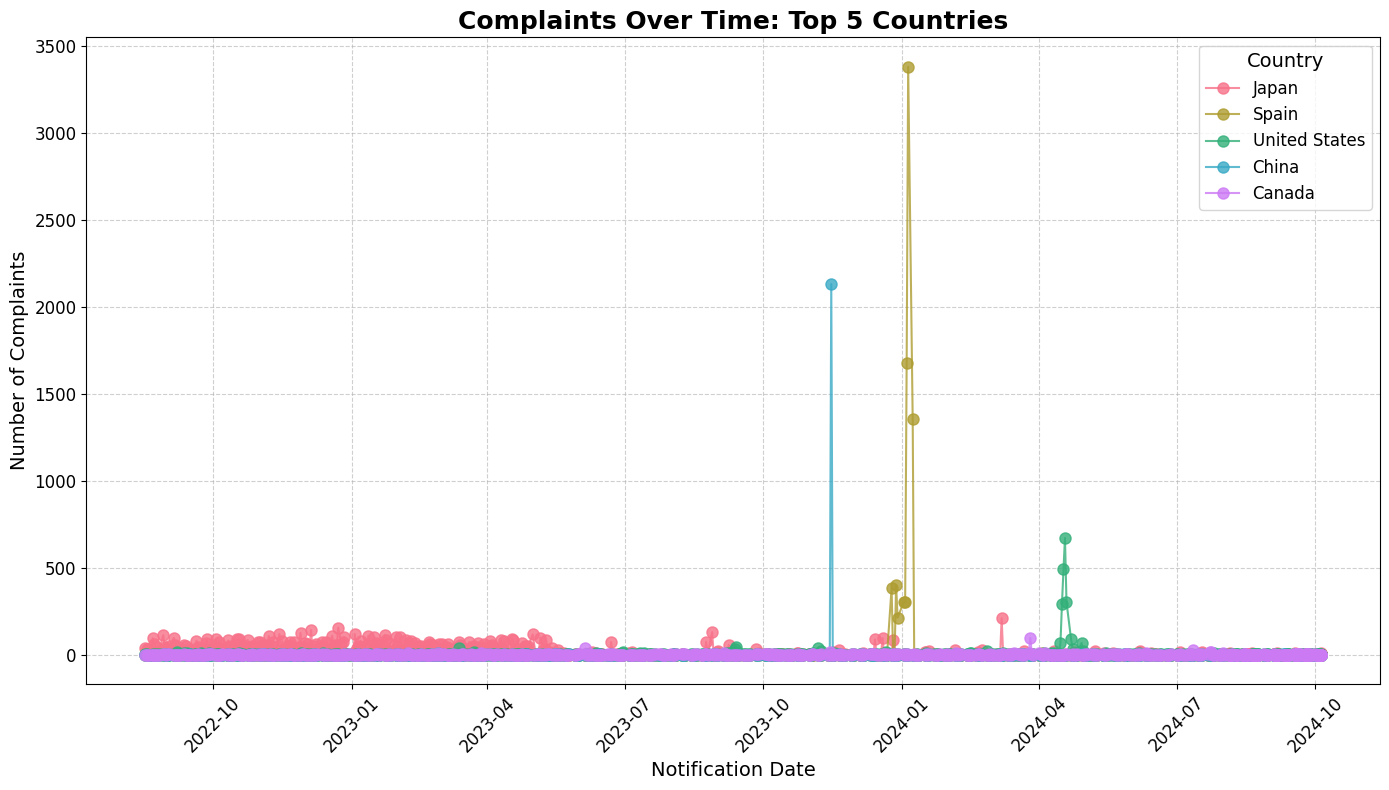

In [121]:
# Convert Notification Date to datetime
notifications_df['Notification Date'] = pd.to_datetime(notifications_df['Notification Date'])

# Group by Country and count total complaints per country
complaints_by_country = notifications_df.groupby('Country').size()

# Find the top 5 countries with the most complaints
top_5_countries = complaints_by_country.nlargest(5).index

# Group by Country and Notification Date, then count occurrences for plotting
complaints_over_time = notifications_df.groupby(['Country', 'Notification Date']).size().unstack(fill_value=0)

# Set up the color palette from Seaborn
palette = sns.color_palette('husl', len(top_5_countries))

# Plot for the top 5 countries
plt.figure(figsize=(14, 8))
lines_top_5 = []
for idx, country in enumerate(top_5_countries):
    line, = plt.plot(complaints_over_time.columns, complaints_over_time.loc[country], 
                     marker='o', markersize=8, linestyle='-', label=country, 
                     color=palette[idx], alpha=0.8)
    lines_top_5.append(line)

# Adding labels and title
plt.xlabel('Notification Date', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.title('Complaints Over Time: Top 5 Countries', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Country', loc='upper right', fontsize=12, title_fontsize=14)
plt.show()

/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_21699/361240381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_time_df['Sentiment'] = sentiments_time_df['Short Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


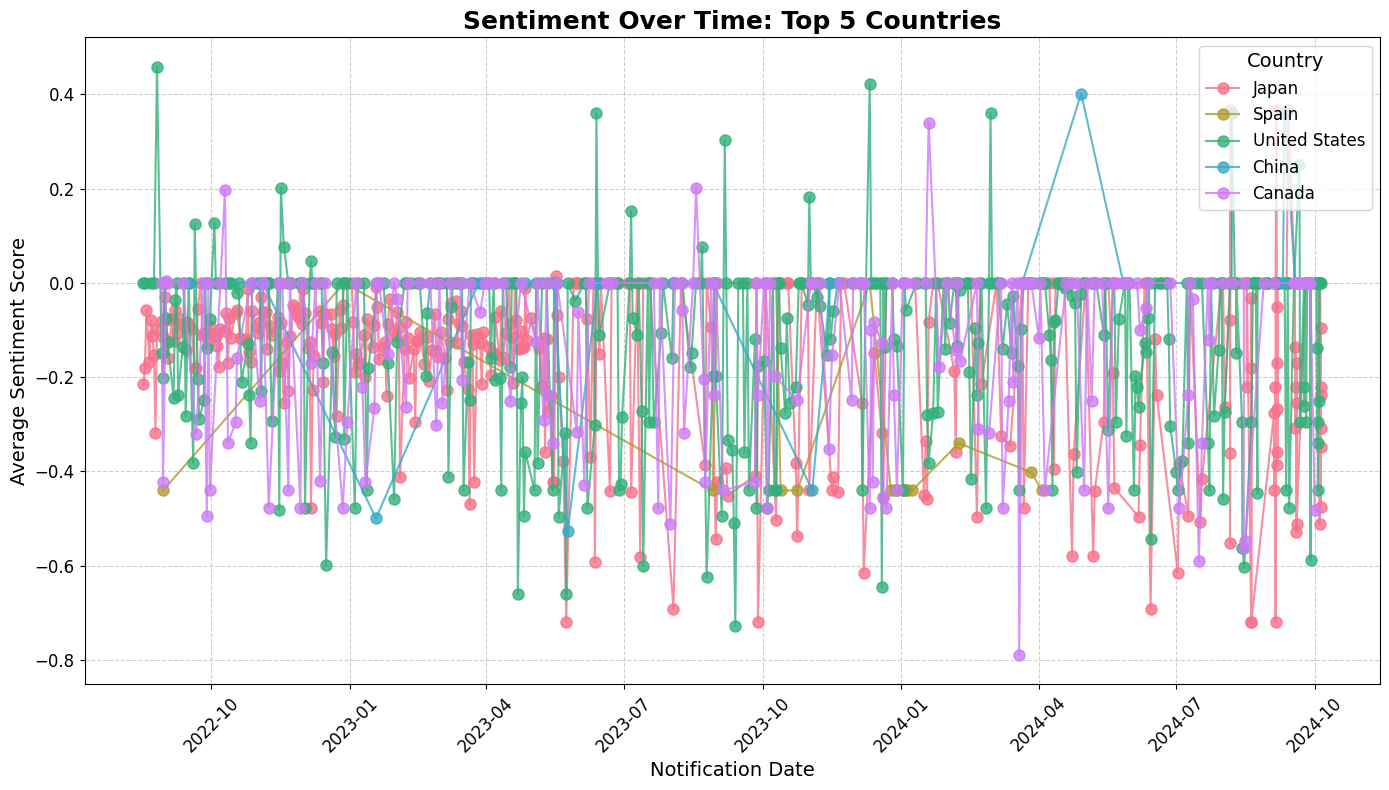

In [122]:
# Convert Notification Date to datetime
complaints_df['Notification Date'] = pd.to_datetime(complaints_df['Notification Date'])

# Group data by Country and Notification Date
sentiments_time_df = complaints_df[['Country', 'Notification Date', 'Short Text']]

# Perform sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()
sentiments_time_df['Sentiment'] = sentiments_time_df['Short Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Find the top 5 countries with the most complaints
top_5_countries = complaints_df.groupby('Country').size().nlargest(5).index

# Filter the dataframe for the top 5 countries
filtered_sentiments_time_df = sentiments_time_df[sentiments_time_df['Country'].isin(top_5_countries)]

# Group by Country and Notification Date and take the average sentiment, ignoring non-numeric columns
average_sentiments = filtered_sentiments_time_df.groupby(['Country', 'Notification Date'])['Sentiment'].mean().reset_index()

# Set up the color palette from Seaborn
palette = sns.color_palette('husl', len(top_5_countries))

# Plot sentiments over time for the top 5 countries
plt.figure(figsize=(14, 8))
for idx, country in enumerate(top_5_countries):
    country_data = average_sentiments[average_sentiments['Country'] == country]
    plt.plot(country_data['Notification Date'], country_data['Sentiment'], 
             marker='o', markersize=8, linestyle='-', label=country, color=palette[idx], alpha=0.8)

# Adding labels and title
plt.xlabel('Notification Date', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.title('Sentiment Over Time: Top 5 Countries', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Country', loc='upper right', fontsize=12, title_fontsize=14)
plt.show()

In [123]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michellechang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michellechang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_21699/2928217322.py:36: UserWarning: Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from current font.
  plt.tight_layout()
/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_21699/2928217322.py:36: UserWarning: Glyph 65404 (\N{HALFWIDTH KATAKANA LETTER SI}) missing from current font.
  plt.tight_layout()
/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_21699/2928217322.py:36: UserWarning: Glyph 65438 (\N{HALFWIDTH KATAKANA VOICED SOUND MARK}) missing from current font.
  plt.tight_layout()
/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_21699/2928217322.py:36: UserWarning: Glyph 65386 (\N{HALFWIDTH KATAKANA LETTER SMALL E}) missing from current font.
  plt.tight_layout()
/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_21699/2928217322.py:36: UserWarning: Glyph 65433 (\N{HALFWIDTH KATAKANA LETTER RU}) missing from current font.
  plt.tight_layout()
/var/folders/j2/0vyt056x6wsb7gmp2w

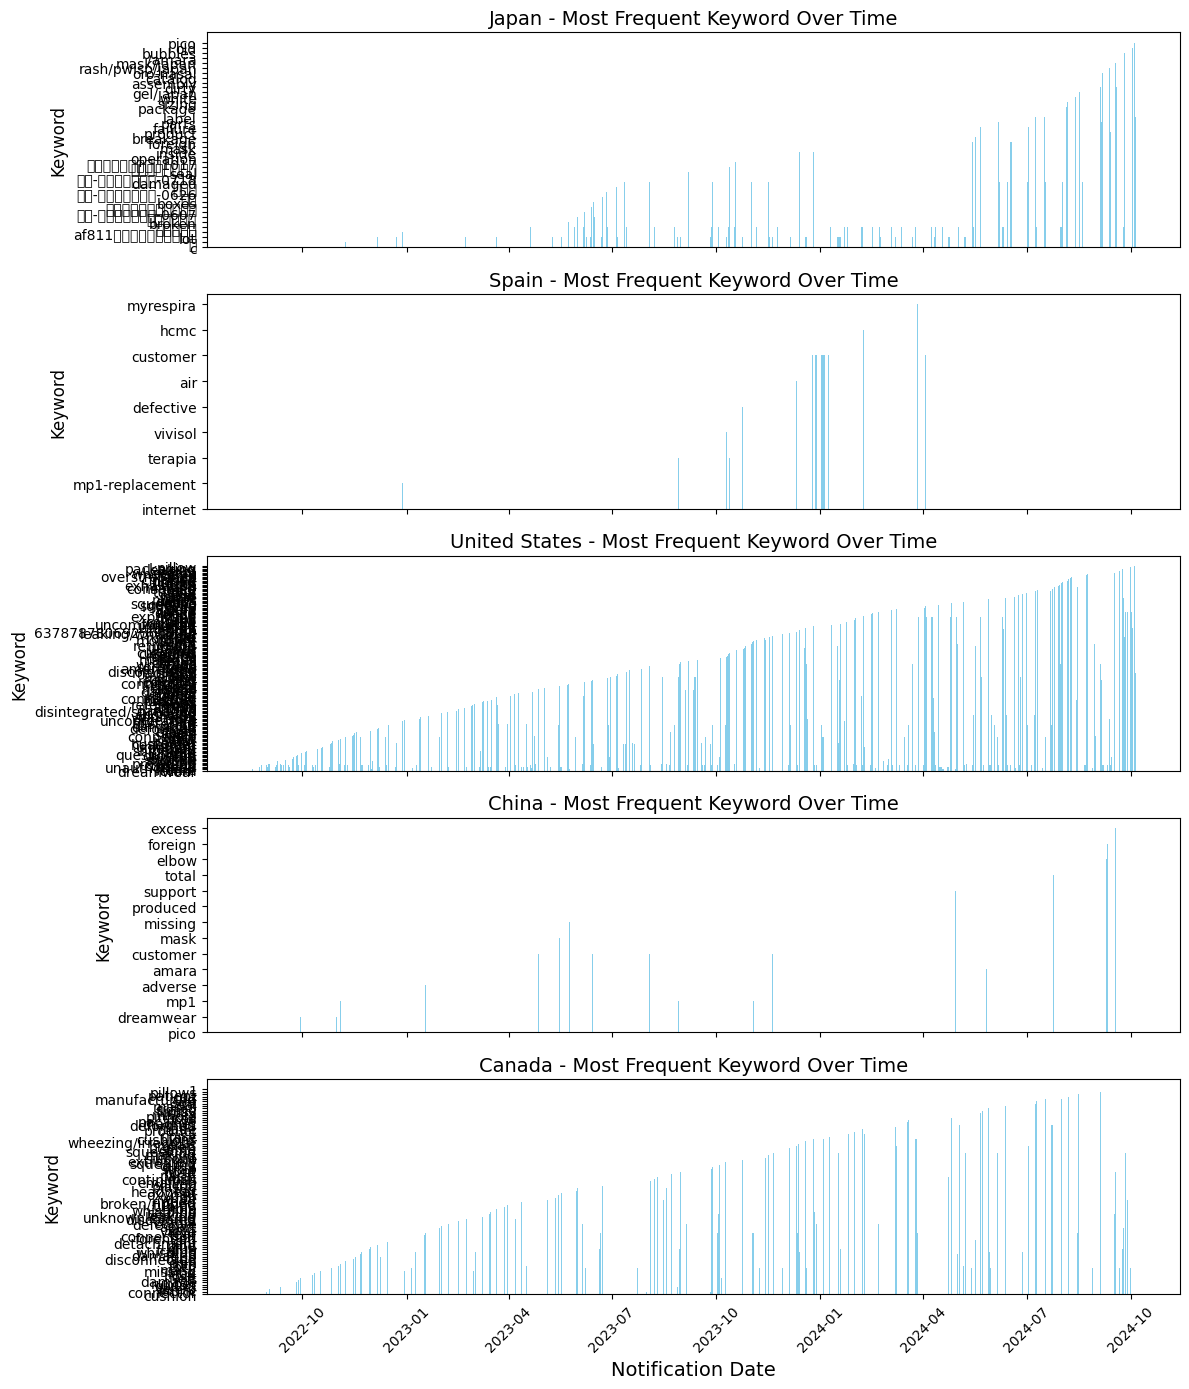

In [125]:
# Convert Notification Date to datetime
complaints_df['Notification Date'] = pd.to_datetime(complaints_df['Notification Date'])

# Filter for the top 5 countries
top_5_countries = complaints_df.groupby('Country').size().nlargest(5).index
filtered_df = complaints_df[complaints_df['Country'].isin(top_5_countries)]

# Function to extract most frequent keyword
def most_frequent_keyword(texts):
    tokens = []
    stop_words = set(stopwords.words('english')) | set(string.punctuation)
    
    for text in texts:
        words = nltk.word_tokenize(text.lower())
        tokens.extend([word for word in words if word not in stop_words])
    
    if tokens:
        return Counter(tokens).most_common(1)[0][0]  # Return most common word
    return None

# Group by Notification Date and find most frequent keyword
keyword_over_time = filtered_df.groupby(['Country', 'Notification Date'])['Short Text'].apply(most_frequent_keyword).reset_index()

# Plot the most frequent keywords over time using subplots
fig, axs = plt.subplots(len(top_5_countries), 1, figsize=(12, 14), sharex=True)

for idx, country in enumerate(top_5_countries):
    country_data = keyword_over_time[keyword_over_time['Country'] == country]
    axs[idx].bar(country_data['Notification Date'], country_data['Short Text'], color='skyblue')
    axs[idx].set_title(f'{country} - Most Frequent Keyword Over Time', fontsize=14)
    axs[idx].tick_params(axis='x', labelrotation=45, labelsize=10)
    axs[idx].set_ylabel('Keyword', fontsize=12)

# Common X label
plt.xlabel('Notification Date', fontsize=14)
plt.tight_layout()
plt.show()